In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, confusion_matrix

Для начал считаем предложенные данные и добавим байтовый столбец, где 1 это положительный отзыв, а 0 - отрицательный.

In [133]:
df = pd.DataFrame(pd.read_csv(r'/content/good_bad.csv'))
df['категории'] = df['разметка'].apply(lambda x: 1 if x == '+' else 0)
df = df.drop(['разметка'], axis=1)
df.head()

,отзывы,категории
0,Оболочка после чистого андроида тоже очень нек...,0
1,"Нормальный телефон, очень красивая задняя панель",1
2,Деньги на ветер .,0
3,ну так себе,0
4,Ценник вполне адекватный для такой мощной нови...,1


Теперь разделим нашу выборку на тренировочную и тестовую часть в отношении 8.5 к 1.5:

In [134]:
X = df.drop(['категории'], axis=1)
y = df['категории']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=33)

Введем класс CountVectorizer(), который позволит нам преобразовать наши строки отзывов в байтовые строки, где каждый байт отвечает за факт появления слова в конкретном отзыве:

In [135]:
cv = CountVectorizer(binary=True)
X_train_matrix = cv.fit_transform(X_train['отзывы'])
matrix_train = pd.DataFrame(X_train_matrix.toarray(), columns=cv.get_feature_names_out())
matrix_train.head()

,10,100,108мп,15,20,48мп,50мп,70тыс,90,calculations,max,pro,qphone,quantum,rapid,автоматически,авторегулировка,адекватный,айфон,айфона,аккумулятор,аккумулятора,активно,аналога,андроида,аппарат,аппарата,барахлит,батареи,батарею,батарея,без,бережного,берите,бесит,беспроводной,бетон,ближайшее,блин,блока,блокировки,более,больше,большие,большое,большой,бомба,брак,брал,брала,...,целая,целом,целости,цена,цене,ценник,ценовой,цену,цикличная,часа,часов,часто,чем,через,честно,четко,чехол,чистого,что,чувствительный,чувство,чудо,чуть,чёткое,чёткости,шаг,шикарный,шляпа,шнурок,шоколадка,шоколадку,шумы,шустрый,шёл,экран,экране,экраном,эстонские,эта,этажа,это,этого,этой,этот,эту,явно,якобы,яркий,ярком,яркости
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Далее введем класс MultinomialNB(). Этот класс, который отвечает за наивный Байесовский классификатор, который решает задачу мультиклассовой классификации (в нашем случае бинарной), пользуясь теоремой Байеса:

In [136]:
model = MultinomialNB()
model.fit(matrix_train, y_train)

MultinomialNB()

In [137]:
X_test_matrix = cv.transform(X_test['отзывы'])
matrix_test = pd.DataFrame(X_test_matrix.toarray(), columns=cv.get_feature_names_out())
predicts = model.predict(matrix_test)

Обучив нашу модель Байесовского классификатора на тренировочных данных оценим ее качество с помощью нескольких метрик. Для начала рассчитаем f1-меру:

In [138]:
f1 = f1_score(predicts, y_test)
print(f'f1-мера для Байесовского классификатора: {f1}.')

f1-мера для Байесовского классификатора: 0.9.


Теперь рассчитаем accuracy нашего классификатора:

In [139]:
accuracy = accuracy_score(predicts, y_test)
print(f'accuracy для Байесовского классификатора: {accuracy}.')

accuracy для Байесовского классификатора: 0.875.


Наконец, построим ROC-кривую для еще одной оценки нашей модели, также выведем AUC нашей кривой для дополнительного понимания качества модели:

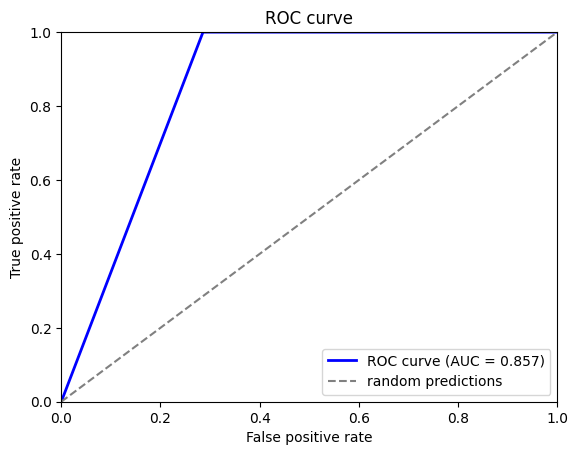

In [140]:
fpr, tpr, thresholds = roc_curve(y_test, predicts)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random predictions')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

Подводя итог, можно сказать, что наша модель, обученная на предложенном тренировочном датасете, успешно научилась разделять отзывы на положительные и отрицательные. Ее AUC составляет 0.86, что свидетельствует о качестве классификатора. Стоит также отметить, что f1-мера, являющаяся средним гармоническим между Precision и Recall, велика, что свидельствует о том, что наша модель научилась эффективно определять именно положительные отзывы.

